In [ ]:
BASEDIR='/content/drive/MyDrive/recommender system/ml-latest-small'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
movies=pd.read_csv(f'{BASEDIR}/movies.csv')
ratings=pd.read_csv(f'{BASEDIR}/ratings.csv')
tags=pd.read_csv(f'{BASEDIR}/tags.csv')
links=pd.read_csv(f'{BASEDIR}/links.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# item-item collaborative filtering

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


In [ ]:
user_freq = ratings.groupby('userId').agg({'movieId':'count'}).reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


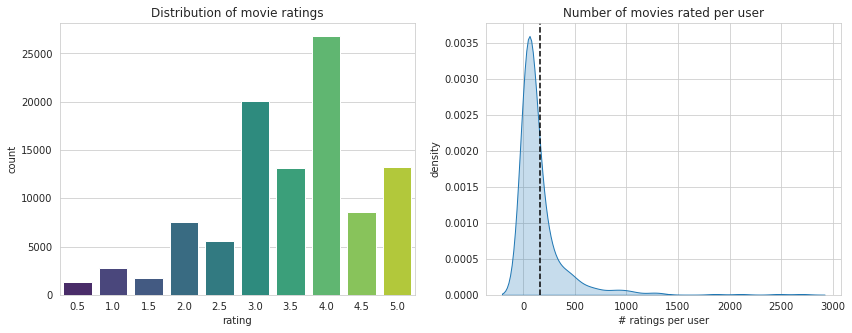

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

In [ ]:
movie_rating_ = ratings.groupby('movieId').agg({'rating':('mean','count')})
movie_rating_ = movie_rating_['rating'].reset_index()
movie_rating_ 

,movieId,mean,count
0,1,3.920930,215
1,2,3.431818,110
2,3,3.259615,52
3,4,2.357143,7
4,5,3.071429,49
...,...,...,...
9719,193581,4.000000,1
9720,193583,3.500000,1
9721,193585,3.500000,1
9722,193587,3.500000,1


In [ ]:
movie_rating_[movie_rating_['mean']==movie_rating_['mean'].min()]

,movieId,mean,count
2685,3604,0.5,1
2929,3933,0.5,1
3023,4051,0.5,1
3230,4371,0.5,1
3364,4580,0.5,2
...,...,...,...
9401,165645,0.5,1
9426,167296,0.5,1
9540,173307,0.5,1
9572,175475,0.5,1


In [ ]:
movie_rating_[(movie_rating_['mean']==movie_rating_['mean'].max()) & (movie_rating_['count']>=50)]

,movieId,mean,count


### Normalizing data

In [ ]:
all_C = movie_rating_['count'].mean()
all_m = movie_rating_['mean'].mean()

def bayesian_avg(ratings_per_movie):
    bayesian_avg = (all_C*all_m+ratings_per_movie.sum())/(all_C+ratings_per_movie.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_rating_.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
movie_stats

,movieId,mean,count,bayesian_avg
0,1,3.920930,215,3.890632
1,2,3.431818,110,3.417227
2,3,3.259615,52,3.260086
3,4,2.357143,7,2.897612
4,5,3.071429,49,3.104793
...,...,...,...,...
9719,193581,4.000000,1,3.327318
9720,193583,3.500000,1,3.283341
9721,193585,3.500000,1,3.283341
9722,193587,3.500000,1,3.283341


In [ ]:
movie_stats['bayesian_avg'].min(),movie_stats['bayesian_avg'].max()

(2.1903773013209, 4.392069545182311)

In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,mean,count,bayesian_avg
1172,1556,1.605263,19,2.190377
2679,3593,1.657895,19,2.224426
1372,1882,1.954545,33,2.267268
1144,1499,1.925926,27,2.296800
1988,2643,1.687500,16,2.306841


In [ ]:
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,mean,count,bayesian_avg
277,318,4.429022,317,4.392070
659,858,4.289062,192,4.236457
2224,2959,4.272936,218,4.227052
224,260,4.231076,251,4.192646
46,50,4.237745,204,4.190567


### sparse matrix

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
   
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_X(ratings)

In [ ]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [ ]:
X

<9724x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [ ]:
X[1].toarray().shape

(1, 610)

### KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


# SVD

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
len(ratings['userId'].unique()),len(ratings['movieId'].unique())

(610, 9724)

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
   
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_X(ratings)

In [ ]:
X.toarray().shape

(9724, 610)

In [ ]:
from scipy.sparse.linalg import svds

In [ ]:
U,sigma,Vt=svds(X,k=50)

In [ ]:
sigma=np.diag(sigma)

In [ ]:
U.shape,sigma.shape,Vt.shape

((9724, 50), (50, 50), (50, 610))

In [ ]:
pred_ratings=np.dot(np.dot(U,sigma),Vt)

In [ ]:
pred_ratings.shape

(9724, 610)

In [ ]:
predicted_ratings=pd.DataFrame(pred_ratings)
predicted_ratings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
0,2.181872,0.209809,0.013394,2.012072,1.336714,4.306055,2.208977,1.109001,0.113559,0.675468,1.716671,0.010000,-0.098274,0.645638,2.098040,1.232723,2.264642,2.460229,4.709561,2.923546,2.693979,1.297666,0.200880,1.059699,0.609467,0.165429,2.888381,-0.454502,0.518599,0.988328,2.758644,3.767417,1.606362,0.539407,0.157375,0.136999,0.613736,1.040858,1.600421,1.413597,...,0.137036,2.791939,5.578597,0.343142,-0.095983,-0.014891,1.435149,-0.048979,2.014588,1.742761,1.352118,0.585607,0.522489,1.672456,-0.049416,2.711499,2.797298,0.509524,1.203331,3.288467,0.444934,1.965787,2.553474,2.027872,0.313512,2.567899,5.374036,0.318846,2.657543,3.977487,3.560629,2.283453,3.380645,1.522485,2.391375,2.479239,2.818179,2.309635,0.783183,5.358093
1,0.393674,0.004821,0.034726,-0.394882,0.772954,3.849228,0.859955,1.146065,0.288594,0.102242,0.602665,0.124246,-0.121256,0.683985,0.859996,-0.457812,0.041942,3.849028,2.698390,2.189256,1.778305,0.193832,-0.397887,0.167592,-0.017579,0.476689,1.763012,0.226537,0.445285,0.119833,0.641193,0.391482,-0.141666,0.195276,0.460545,-0.060008,0.558730,1.262469,0.209022,1.822995,...,0.429400,0.551140,1.950171,0.656856,-0.137652,-0.000127,0.800768,0.066227,0.599367,1.607486,0.125362,0.131197,0.432736,2.661357,-0.390092,1.174680,1.034561,0.540209,0.570151,3.246661,-0.095759,2.344015,0.349422,2.564584,-0.117388,1.604365,1.067228,-0.008163,2.708139,4.550989,-0.146901,1.714205,-0.377834,1.849796,1.760291,-0.068356,1.371977,2.702439,0.530143,-0.288817
2,0.838186,0.030742,0.050525,-0.290386,0.064577,3.196092,-0.039753,0.294364,0.074111,-0.224689,0.405239,0.115108,-0.153590,0.548836,-0.180927,-0.092048,0.023366,0.109222,2.000323,0.025029,-0.120730,0.071496,-0.414494,-0.006213,0.023767,0.032297,0.413999,-0.590216,0.030228,-0.141569,0.789536,1.565488,-0.166019,-0.153873,0.094898,0.157649,0.265257,0.366055,-0.399836,0.614136,...,0.225922,0.337334,0.328095,0.126112,0.004857,0.024134,0.242478,-0.037987,-0.088645,-0.488926,-0.107004,-0.067613,0.001486,0.476036,0.330375,-0.276102,0.538239,0.302160,0.568657,1.875575,-0.028690,0.842344,0.078985,0.719226,-0.011073,-1.178062,0.424052,-0.006279,1.595601,2.765042,-0.566114,1.076104,0.362134,0.878637,0.407061,0.013008,0.327078,2.264197,0.097975,-0.090768
3,-0.082365,0.017252,0.000200,0.093864,0.113880,0.622321,-0.056967,0.117811,0.032433,-0.041160,0.021698,0.042264,-0.014976,0.145587,-0.008524,0.024721,0.008184,0.137511,0.028853,-0.033989,-0.203599,-0.059522,-0.037486,0.014373,0.042563,0.023935,0.018799,-0.016745,-0.016646,0.052726,0.122793,0.376579,0.202699,-0.092564,0.091860,-0.001825,0.037400,0.216493,-0.018242,0.257819,...,0.025972,0.128626,-0.099820,0.035871,-0.005629,-0.001305,0.012030,0.003907,-0.030662,-0.062634,-0.000493,0.027615,-0.004734,0.150068,-0.019727,0.078112,0.158410,0.101311,0.173545,-0.087885,-0.038112,0.133726,0.030094,0.067872,0.001702,0.096109,-0.075238,-0.019495,0.004446,0.594903,-0.062567,0.321706,0.248538,0.227477,0.059860,0.079384,0.007047,0.020182,0.025595,-0.038458
4,-0.546279,0.183764,-0.005577,0.123312,0.274994,3.322205,0.069266,0.209637,0.049234,0.244035,0.395758,0.241394,-0.184456,0.497865,-0.123660,-0.028772,0.038264,0.919981,0.585852,0.158673,-0.175417,0.157557,0.116063,-0.043608,0.162191,-0.097591,0.293565,-0.035138,-0.123369,0.207790,1.140590,1.896701,0.261480,-0.242179,0.199980,0.000109,0.038978,0.559903,-0.575696,0.769337,...,-0.011801,0.234847,0.780932,-0.027451,-0.110195,-0.016900,-0.113949,0.060410,0.175803,-0.705383,0.038484,0.162069,0.148279,0.580993,0.031146,0.267753,0.442130,0.123156,0.486679,0.742831,-0.181859,0.738864,0.170031,0.926939,0.052201,0.086329,0.114202,-0.023611,0.037417,2.838308,0.114557,1.182828,0.100867,0.946972,0.611752,-0.177777,-0.280580,0.152228,0.090406,0.160

In [ ]:
#Enter User ID
index_number=10
top_movies=predicted_ratings.iloc[:,index_number].sort_values(ascending=False)

In [ ]:
top10_movie_ids=[movie_inv_mapper[i] for i in top_movies.index][:10]

In [ ]:
movies[movies['movieId'].apply(lambda x: x in top10_movie_ids)]

,movieId,title,genres
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
334,377,Speed (1994),Action|Romance|Thriller
337,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
398,457,"Fugitive, The (1993)",Thriller
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
507,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
546,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller


# TruncatedSVD

In [ ]:
from scipy.sparse import csr_matrix

def create_X(df):
   
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_X(ratings)

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd=TruncatedSVD(n_components=10) #n_movies and 10 users
matrix=svd.fit_transform(X)

In [ ]:
matrix.shape

(9724, 10)

In [ ]:
corr_matrix=np.corrcoef(matrix)

In [ ]:
np.sort(corr_matrix[0])[-10:]

array([0.92742763, 0.92866824, 0.93265409, 0.93536852, 0.94348873,
       0.94718741, 0.94791186, 0.94837538, 0.96021163, 1.        ])

# song recommender

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
song_df=pd.read_csv('/content/drive/MyDrive/recommender system/song_data.csv')

In [ ]:
song_df.head()

,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters


In [ ]:
def song_name(data):
  return data.iloc[0]
def title_name(data):
  return data.iloc[0]
def artist_name(data):
  return data.iloc[0]
song_info=song_df.groupby('song_id').agg({'song':song_name,'title':title_name,'artist':artist_name})

In [ ]:
song_info=song_info.reset_index()
song_info

,song_id,song,title,artist
0,SOAAAGQ12A8C1420C8,Orgelblut - Bohren & Der Club Of Gore,Orgelblut,Bohren & Der Club Of Gore
1,SOAACPJ12A81C21360,Cearc Agus Coileach / The Hen And Cock - Míche...,Cearc Agus Coileach / The Hen And Cock,Mícheál Ó Súilleabháin
2,SOAACSG12AB018DC80,I Gotta Feeling (Edit) - The Black Eyed Peas,I Gotta Feeling (Edit),The Black Eyed Peas
3,SOAAEJI12AB0188AB5,Godlovesugly - Atmosphere,Godlovesugly,Atmosphere
4,SOAAFAC12A67ADF7EB,Rome Wasn't Built In A Day - Morcheeba,Rome Wasn't Built In A Day,Morcheeba
...,...,...,...,...
9995,SOZZTNF12A8C139916,Le Million - Ste Strausz,Le Million,Ste Strausz
9996,SOZZVWB12AB0189C30,Recovered - Marco V,Recovered,Marco V
9997,SOZZWZV12A67AE140F,Henrietta - The Fratellis,Henrietta,The Fratellis
9998,SOZZYAO12A6701FF36,Sunset (Bird Of Prey) - Fatboy Slim,Sunset (Bird Of Prey),Fatboy Slim


In [ ]:
song_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   song_id  10000 non-null  object
 1   song     10000 non-null  object
 2   title    10000 non-null  object
 3   artist   10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB


In [ ]:
song_grouped = song_df.groupby(['song_id']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped
# song_grouped.sort_values(['listen_count', 'song_id'], ascending = [0,1])

,song_id,listen_count,percentage
0,SOAAAGQ12A8C1420C8,34,0.003045
1,SOAACPJ12A81C21360,54,0.004836
2,SOAACSG12AB018DC80,49,0.004388
3,SOAAEJI12AB0188AB5,31,0.002776
4,SOAAFAC12A67ADF7EB,98,0.008777
...,...,...,...
9995,SOZZTNF12A8C139916,176,0.015762
9996,SOZZVWB12AB0189C30,65,0.005821
9997,SOZZWZV12A67AE140F,64,0.005732
9998,SOZZYAO12A6701FF36,31,0.002776


In [ ]:
song_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   song_id       10000 non-null  object 
 1   listen_count  10000 non-null  int64  
 2   percentage    10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [ ]:
songs=song_grouped.merge(song_info,how='left',on='song_id')
songs

,song_id,listen_count,percentage,song,title,artist
0,SOAAAGQ12A8C1420C8,34,0.003045,Orgelblut - Bohren & Der Club Of Gore,Orgelblut,Bohren & Der Club Of Gore
1,SOAACPJ12A81C21360,54,0.004836,Cearc Agus Coileach / The Hen And Cock - Míche...,Cearc Agus Coileach / The Hen And Cock,Mícheál Ó Súilleabháin
2,SOAACSG12AB018DC80,49,0.004388,I Gotta Feeling (Edit) - The Black Eyed Peas,I Gotta Feeling (Edit),The Black Eyed Peas
3,SOAAEJI12AB0188AB5,31,0.002776,Godlovesugly - Atmosphere,Godlovesugly,Atmosphere
4,SOAAFAC12A67ADF7EB,98,0.008777,Rome Wasn't Built In A Day - Morcheeba,Rome Wasn't Built In A Day,Morcheeba
...,...,...,...,...,...,...
9995,SOZZTNF12A8C139916,176,0.015762,Le Million - Ste Strausz,Le Million,Ste Strausz
9996,SOZZVWB12AB0189C30,65,0.005821,Recovered - Marco V,Recovered,Marco V
9997,SOZZWZV12A67AE140F,64,0.005732,Henrietta - The Fratellis,Henrietta,The Fratellis
9998,SOZZYAO12A6701FF36,31,0.002776,Sunset (Bird Of Prey) - Fatboy Slim,Sunset (Bird Of Prey),Fatboy Slim


In [ ]:
users = song_df['user_id'].unique()
len(users)

66346

In [ ]:
def songs_of_user(data):
  return list(data)
df1=song_df.groupby('user_id')['song_id'].agg(songs_of_user).reset_index()
df1.columns=['user_id','songs_of_user']
df2=song_df.groupby('song_id')['user_id'].agg(songs_of_user).reset_index()
df2.columns=['song_id','users_of_song']
#then create co-occurence matrix

In [ ]:
df1

,user_id,songs_of_user
0,00003a4459f33b92906be11abe0e93efc423c0ff,"[SOJJRVI12A6D4FBE49, SOKJWZB12A6D4F9487, SOMZH..."
1,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,"[SOGMLKG12AB018CF9B, SOGMLQO12A670207BF, SOGNV..."
2,00030033e3a2f904a48ec1dd53019c9969b6ef1f,"[SOBONKR12A58A7A7E0, SOGPKAP12AF72A1F36, SONBB..."
3,0007235c769e610e3d339a17818a5708e41008d9,"[SOCGWCK12A67020F39, SOCTMPN12A58A799E5, SOEIY..."
4,0007c0e74728ca9ef0fe4eb7f75732e8026a278b,"[SOBZZDU12A6310D8A3, SOCHADN12A6310ED94, SOFEL..."
...,...,...
66341,fffce9c1537fbc350ea68823d956eaa8f5236dbe,"[SOAUWYT12A81C206F1, SOAXGDH12A8C13F8A1, SOBON..."
66342,fffd6a2bdef646ce9898b628d5dd56c43df69a9d,"[SOBOHSG12AB0183748, SOBSQYL12AB0187688, SOCSO..."
66343,fffd9635b33f412de8ed02e44e6564e3644cf3c6,"[SOAPHBN12AF72A60EF, SOCJHXN12AB0188C8B, SOGTG..."
66344,fffe6d1d8500f1c1f31bd63abce35c0f975a86bf,"[SOITBKC12A58A7C01F, SOLXTXN12AB018238A, SONTF..."


In [ ]:
df2

,song_id,users_of_song
0,SOAAAGQ12A8C1420C8,"[be0db87ab60e3a2de60354f34d9e37341b65eb1e, 9ce..."
1,SOAACPJ12A81C21360,"[fb2f2c0e39e233622c300c232a6287738007e34a, 0aa..."
2,SOAACSG12AB018DC80,"[c0527e248aeff22816b97f8a2428ff0d2a40f647, aa3..."
3,SOAAEJI12AB0188AB5,"[28b232e7ecb32c47c05b795a017786d4be96ef7e, 6bd..."
4,SOAAFAC12A67ADF7EB,"[fdb815231ee1d66f383b80d279bd58769dfe59ff, 83d..."
...,...,...
9995,SOZZTNF12A8C139916,"[fbd14aa950314d4ea7f64c50f8b357d364a5b94c, f58..."
9996,SOZZVWB12AB0189C30,"[905e0bb88e1f84e1e59a597218ab626ceb9c9f3e, 079..."
9997,SOZZWZV12A67AE140F,"[956044d724390e40c8511b49e5bf6bc28071de3a, 1dc..."
9998,SOZZYAO12A6701FF36,"[bf6da922a29e2474a08b93f775211c6d6a470475, f6c..."


In [ ]:
user_id=df1.iloc[0]['user_id']
user_songs=df1[df1['user_id']==user_id]['songs_of_user'].values[0]
user_songs

['SOJJRVI12A6D4FBE49',
 'SOKJWZB12A6D4F9487',
 'SOMZHIH12A8AE45D00',
 'SONFEUF12AAF3B47E3',
 'SOVMGXI12AF72A80B0',
 'SOVNPBK12A6D4F6A67',
 'SOWVBDQ12A8C13503D']

In [ ]:
df2[df2['song_id']==user_songs[0]]

,song_id,users_of_song
3731,SOJJRVI12A6D4FBE49,"[3dd5f55c9716354f0e65c804debad68171fb367d, c2e..."


In [ ]:
user_df=df2[df2['song_id'].apply(lambda x: x in user_songs)==True]
user_df

,song_id,users_of_song
3731,SOJJRVI12A6D4FBE49,"[3dd5f55c9716354f0e65c804debad68171fb367d, c2e..."
4125,SOKJWZB12A6D4F9487,"[5db96afeb6a4d7c3731531ade2b94e26f4fc1634, b72..."
5146,SOMZHIH12A8AE45D00,"[7dd192c8bd4f27f573cb15e8656442aadd7a9c01, 5d5..."
5228,SONFEUF12AAF3B47E3,"[6ac64072cb8f308f36c64cc4aafb6021fef70476, 25c..."
8366,SOVMGXI12AF72A80B0,"[f5e8cc6983d563ff255988b9ea0c53e67941f71e, 685..."
8375,SOVNPBK12A6D4F6A67,"[645a5b400d31ce69611137da3ebd35d11d4dda4a, 24b..."
8866,SOWVBDQ12A8C13503D,"[e188e309e19e0847a05156d6efecc04e4bff4fc7, 25c..."


In [ ]:
def inside_coocurence_matrix(users_of_song_i,users_of_song_j):
  users_of_song_i=np.array(users_of_song_i)
  users_of_song_j=np.array(users_of_song_j)
  intersection=np.intersect1d(users_of_song_i,users_of_song_j)
  union=set(users_of_song_i).union(set(users_of_song_j))
  return len(intersection)/len(union)

def coocurence_matrix(users_of_song_i,data):
  print(len(users_of_song_i))
  arr=data.apply(lambda x: inside_coocurence_matrix(users_of_song_i,x['users_of_song']),axis=1)
  return arr

data=user_df.apply(lambda x: coocurence_matrix(x['users_of_song'],df2),axis=1)

100
55
66
91
211
64
378


In [ ]:
data.column=df2['song_id'].values
data.index=user_df['song_id'].values
data

,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAEJI12AB0188AB5,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAJMQ12A6D4F7D17,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAMOW12AB018149B,SOAAOYI12AB01831CE,SOAAROC12A6D4FA420,SOAARXR12A8C133D15,SOAATHE12A8C13ADD6,SOAATLI12A8C13E319,SOAAUKC12AB017F868,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABGOB12A6701D1FA,SOABHNP12A8AE46E82,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,SOABJTC12A58A7DE0E,SOABNLP12A6D4F87F4,SOABNPW12A6D4FC9B5,SOABOHM12AB018509C,SOABOXV12AC3DF82F7,SOABPQU12A58A78441,SOABQTG12A6701F3DB,SOABRAB12A6D4F7AAF,SOABTTR12A6D4FC2EB,SOABXNE12A8C13B818,SOACBLB12AB01871C7,SOACDMD12A67AD8332,SOACERJ12A67AD865E,SOACGVR12A8C13B60A,SOACIPG12A8AE47E1C,SOACKIA12A6D4F73D7,SOACMJJ12A6D4FC66A,SOACNQJ12A8C13B09E,...,SOZXEZV12A6D4F737F,SOZXHNM12AB017CDEA,SOZXHRP12A6D4F9A2C,SOZXHYA12A8C145274,SOZXKIA12A6D4F861C,SOZXLPJ12A6701F7AB,SOZXMYX12AB018A445,SOZXNVK12A8C13CF0E,SOZXQHF12A58A79168,SOZXQRQ12A6701C323,SOZXSEC12A67020AB5,SOZXSYQ12AB0184F5F,SOZXTAI12A8C134DE1,SOZXTUT12A6D4F6D03,SOZXVUF12AC909762A,SOZXVWK12AB018B865,SOZYBGN12A8C13A93C,SOZYDZR12A8C13F4F0,SOZYIQR12A58A7DB25,SOZYNNT12A81C22E0F,SOZYPRF12A6310F1B4,SOZYSDT12A8C13BFD7,SOZYTWE12A3F1EA18B,SOZYUGZ12A8AE472AC,SOZYUXF12A6701F7B9,SOZZCXT12A6D4FA441,SOZZEID12A58A7AB89,SOZZFTH12A6701E983,SOZZHQT12AB018B714,SOZZIOH12A67ADE300,SOZZKPR12A6D4F8147,SOZZLTY12A67AE0AD0,SOZZLZN12A8AE48D6D,SOZZRHE12A6702165F,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F,SOZZYAO12A6701FF36,SOZZZPV12A8C1444B5
SOJJRVI12A6D4FBE49,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.008197,0.0,0.003968,0.0,0.0,0.000000,0.0,0.000000,0.003185,0.000000,0.000000,0.003676,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.006944,0.000000,0.000000,0.003802,0.006452,0.004739,0.010989,0.000000,0.0,0.002475,0.000000,0.00000,0.005848,...,0.000000,0.0,0.000000,0.0,0.000000,0.009569,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.005376,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.006944,0.000000,0.0,0.0,0.000000,0.009852,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
SOKJWZB12A6D4F9487,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.004831,0.0,0.0,0.000000,0.0,0.000000,0.011236,0.009091,0.009709,0.000000,0.004310,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.009091,0.010753,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.001520,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
SOMZHIH12A8AE45D00,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.008457,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.004367,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.003861,0.0,0.0,0.0,0.001495,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
SONFEUF12AAF3B47E3,0.0,0.006944,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001901,0.000000,0.000000,0.000000,0.000000,0.004000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.003937,0.000000,0.004950,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.004831,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.014493,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.003521,0.0,0.0,0.0,0.001441,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
SOVMGXI12AF72A80B0,0.0,0.003788,0.007752,0.0,0.003247,0.003704,0.003759,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.003356,0.0,0.010937,0.002353,0.000000,0

In [ ]:
data.sum(axis=0).to_dict()

In [ ]:
recommended_songs=sorted(data.sum(axis=0).to_dict(),key=(lambda x: x[1]),reverse=True)[-10:]
recommended_songs

['SOZZKPR12A6D4F8147',
 'SOZZLTY12A67AE0AD0',
 'SOZZLZN12A8AE48D6D',
 'SOZZRHE12A6702165F',
 'SOZZTCU12AB0182C58',
 'SOZZTNF12A8C139916',
 'SOZZVWB12AB0189C30',
 'SOZZWZV12A67AE140F',
 'SOZZYAO12A6701FF36',
 'SOZZZPV12A8C1444B5']

In [ ]:
filtered_recommended_songs=[song for song in recommended_songs if song not in user_songs]

In [ ]:
filtered_recommended_songs

['SOZZKPR12A6D4F8147',
 'SOZZLTY12A67AE0AD0',
 'SOZZLZN12A8AE48D6D',
 'SOZZRHE12A6702165F',
 'SOZZTCU12AB0182C58',
 'SOZZTNF12A8C139916',
 'SOZZVWB12AB0189C30',
 'SOZZWZV12A67AE140F',
 'SOZZYAO12A6701FF36',
 'SOZZZPV12A8C1444B5']

In [ ]:
songs[songs['song_id'].apply(lambda x: x in filtered_recommended_songs)==True]

,song_id,listen_count,percentage,song,title,artist
9990,SOZZKPR12A6D4F8147,49,0.004388,Si Una Vez - Selena,Si Una Vez,Selena
9991,SOZZLTY12A67AE0AD0,51,0.004567,Ruska - Apocalyptica,Ruska,Apocalyptica
9992,SOZZLZN12A8AE48D6D,105,0.009403,Afterlife (Album Version) - Avenged Sevenfold,Afterlife (Album Version),Avenged Sevenfold
9993,SOZZRHE12A6702165F,69,0.006179,Tommy The Cat - Primus,Tommy The Cat,Primus
9994,SOZZTCU12AB0182C58,91,0.008150,Throw Some D's Remix - Rich Boy / Andre 3000 /...,Throw Some D's Remix,Rich Boy / Andre 3000 / Jim Jones / Nelly / Mu...
9995,SOZZTNF12A8C139916,176,0.015762,Le Million - Ste Strausz,Le Million,Ste Strausz
9996,SOZZVWB12AB0189C30,65,0.005821,Recovered - Marco V,Recovered,Marco V
9997,SOZZWZV12A67AE140F,64,0.005732,Henrietta - The Fratellis,Henrietta,The Fratellis
9998,SOZZYAO12A6701FF36,31,0.002776,Sunset (Bird Of Prey) - Fatboy Slim,Sunset (Bird Of Prey),Fatboy Slim
9999,SOZZZPV12A8C1444B5,50,0.004478,Fall Back - Blacks ft. P Money,Fall Back,Blacks ft. P Money


# Surprise

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 10.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617564 sha256=9e10752909c9920a713fb543c6cb570db78f9fa7a2e17ab1f0e3f1943c160607
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset

ratings=pd.read_csv(f'{BASEDIR}/ratings.csv')
print(ratings.head())
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}

df = pd.DataFrame(ratings_dict)
# A reader is still needed but only the rating_scale param is requiered.

reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).

data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
from surprise import SVD,KNNWithMeans
from surprise.model_selection import cross_validate, GridSearchCV

In [ ]:
param_grid = {'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
# cross_validate()
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE'])
grid_search.fit(data)

In [ ]:
print(grid_search.best_score["rmse"])
print(grid_search.best_params["rmse"])

0.8828183452219538
{'lr_all': 0.005, 'reg_all': 0.4}


In [ ]:
sim_options = {
    "name": ["msd", "cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}
# cross_validate()
grid_search_knn = GridSearchCV(KNNWithMeans, param_grid, measures=['RMSE'],cv=3)
grid_search_knn.fit(data)

In [ ]:
print(grid_search_knn.best_score["rmse"])
print(grid_search_knn.best_params["rmse"])

0.905574676274299
{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}}


# From scratch

### svd from scratch

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
df_rating = ratings.copy()
df_rating = df_rating.sample(n=10000, replace=False, random_state=1)
df_rating['movieId'] = df_rating['movieId'].astype(str)

df_mv = movies.copy()
df_mv['id'] = df_mv['movieId'].astype(str)
df_mv.drop('movieId',axis=1,inplace=True)

df_rate_mv_pro = pd.merge(df_mv, df_rating, how='right', left_on=['id'], right_on=['movieId'])


df_rate_mv_pro1 = df_rate_mv_pro[['genres','id','title','userId','movieId', 'rating']]
df_rate_mv_pro1.dropna(inplace=True)
df_mv3 = df_rate_mv_pro1.loc[~df_rate_mv_pro1["id"].str.contains('-')]
print(df_mv3.shape)
df_mv4 = df_mv3.sample(n=df_mv3.shape[0], replace=False, random_state=1)
df_mv4.reset_index(inplace=True)

df_user_le = pd.DataFrame(df_mv4["userId"].tolist(), columns=['user'])
le = LabelEncoder()
df_user_le['user_le'] = le.fit_transform(df_user_le['user'])
df_mv_le = pd.DataFrame(df_mv4["movieId"].tolist(), columns=['movie'])
df_mv_le['mv_le'] = le.fit_transform(df_mv_le['movie'])

user_ids = np.array(df_user_le['user_le'].tolist())
movie_ids = np.array(df_mv_le['mv_le'].tolist())
user_ratings = np.array(df_mv4["rating"].tolist())
print ('num of users:',df_mv4['userId'].nunique())
print ('num of movies:',df_mv4['movieId'].nunique())

(10000, 6)
num of users: 594
num of movies: 3676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
graph = tf.Graph()
n_movie = 3676
n_user = 594
embedding_size = 30

lr = 0.0001
reg = 0.01

with graph.as_default():
    user = tf.placeholder(tf.int32, name="user_id") 
    movie = tf.placeholder(tf.int32, name="movie_id") 
    rating = tf.placeholder(tf.float32, name="rating") 

    movie_embedding = tf.Variable(tf.truncated_normal([n_movie, embedding_size], stddev=0.02, mean=0.) ,name="movie_embedding")
    user_embedding = tf.Variable(tf.truncated_normal([n_user, embedding_size], stddev=0.02, mean=0.) ,name="user_embedding")
    
    movie_bias_embedding = tf.Variable(tf.truncated_normal([n_movie], stddev=0.02, mean=0.) ,name="movie_bias_embedding")
    user_bias_embedding = tf.Variable(tf.truncated_normal([n_user], stddev=0.02, mean=0.) ,name="user_bias_embedding")
    
    global_bias = tf.Variable(tf.truncated_normal([], stddev=0.02, mean=0.) ,name="global_bias")
    
    u = tf.nn.embedding_lookup(user_embedding, user)
    m = tf.nn.embedding_lookup(movie_embedding, movie)
   
    u_bias = tf.nn.embedding_lookup(user_bias_embedding, user)
    m_bias = tf.nn.embedding_lookup(movie_bias_embedding, movie)

    predicted_rating = tf.reduce_sum(tf.multiply(u, m), 1) + u_bias + m_bias + global_bias

    rmse = tf.sqrt(tf.reduce_mean(tf.square(predicted_rating - rating))) # RMSE
    cost = tf.nn.l2_loss(predicted_rating - rating)
    regularization = reg * (tf.nn.l2_loss(movie_embedding) + tf.nn.l2_loss(user_embedding)
                            + tf.nn.l2_loss(movie_bias_embedding) + tf.nn.l2_loss(user_bias_embedding))
    
    loss = cost + regularization
    
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

In [ ]:
batch_size = 5
n_epoch = 2


with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    for _ in range(n_epoch):
        for start in range(0, user_ratings.shape[0] - batch_size, batch_size):
            end = start + batch_size
            _, cost_value= sess.run([optimizer, rmse], feed_dict={user: user_ids[start:end],
                                                  movie: movie_ids[start: end],
                                                  rating: user_ratings[start: end]})

        print ("RMSE", cost_value)
    embeddings = movie_embedding.eval()

RMSE 3.308834
RMSE 3.0913026


### my approach

In [ ]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [ ]:
n_users=len(ratings.userId.unique())
n_movies=len(ratings.movieId.unique())
print(n_users,n_movies)
wd = 2e-4 # weight decay
n_factors = 50 # n_factors i.e. 1 dimension of embeddings (random)
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
print(min_rating,max_rating)

610 9724
0.5 5.0


In [ ]:
movie_rating = ratings.groupby('movieId').agg({'rating':('mean','count')})
all_C = movie_rating['count'].mean()
all_m = movie_rating['mean'].mean()

def bayesian_avg(ratings_per_movie):
    bayesian_avg = (all_C*all_m+ratings_per_movie.sum())/(all_C+ratings_per_movie.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_rating_.merge(bayesian_avg_ratings, on='movieId')

In [ ]:
ratings['rating'].min(),ratings['rating'].max()

In [ ]:
def normalize(row_data):
  count=row_data[row_data!=0].count()
  sum=row_data[row_data!=0].sum()
  row_data=row_data*count/sum
  return row_data
data=ratings_dict_pivot.T.apply(normalize,axis=1)

In [ ]:
data

userId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.020166,0.0,0.0,0.000000,1.020166,0.000000,1.147687,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.637604,0.000000,1.147687,0.892645,1.020166,0.0,0.892645,0.0,0.000000,0.000000,0.0,0.000000,0.765125,0.000000,0.000000,0.0,1.275208,0.765125,0.765125,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.275208,...,0.0,1.020166,1.275208,0.000000,0.0,0.0,0.000000,0.0,1.020166,0.765125,0.0,0.0,0.0,1.275208,0.0,0.0,1.275208,0.000000,0.0,1.020166,0.0,0.000000,0.000000,0.000000,0.000000,1.020166,1.020166,0.0,0.765125,0.637604,1.020166,0.000000,1.020166,0.765125,1.020166,0.637604,1.020166,0.637604,0.765125,1.275208
1,1.227139,0.0,0.0,0.000000,0.000000,1.533923,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.920354,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.920354,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.920354,0.0,0.920354,0.0,0.000000,0.000000,1.227139,0.000000,0.000000,0.000000,0.0,0.460177,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.613569,0.000000,0.000000
2,1.013665,0.0,0.0,0.000000,0.000000,1.013665,0.000000,0.000000,0.0,0.0,1.267081,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.013665,0.000000,0.0,0.000000,0.0,1.013665,1.140373,0.0,0.000000,0.000000,0.886957,0.000000,0.0,0.000000,0.760248,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,1.140373,0.000000,0.0,0.0,1.013665,0.0,0.000000,1.013665,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.267081,0.0,0.886957,0.0,0.760248,0.000000,0.000000,0.000000,0.000000,0.760248,0.0,1.140373,0.000000,0.000000,0.760248,1.013665,0.760248,0.000000,0.000000,0.000000,0.000000,0.000000,1.267081
3,1.257745,0.0,0.0,0.503098,0.000000,1.006196,0.000000,1.006196,0.0,0.0,0.000000,0.0,1.257745,1.257745,0.880421,0.880421,1.006196,1.131970,0.754647,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.006196,0.000000,0.754647,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.754647,0.000000,...,0.0,0.000000,1.257745,1.257745,0.0,0.0,0.000000,0.0,0.000000,1.257745,0.0,0.0,0.0,1.257745,0.0,0.0,0.000000,0.754647,0.0,0.754647,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.006196,0.0,1.006196,1.006196,1.006196,1.257745,0.000000,0.000000,0.000000,0.754647,0.000000,1.131970,0.000000,1.257745
4,1.179873,0.0,0.0,0.000000,0.943898,0.235975,1.061885,1.179873,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.943898,1.061885,1.179873,0.000000,0.0,0.000000,0.0,0.943898,0.943898,0.0,0.000000,0.000000,0.825911,0.825911,0.0,0.000000,1.179873,1.179873,0.0,1.179873,0.0,0.0,1.179873,1.179873,0.000000,...,0.0,0.000000,1.179873,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.179873,0.0,0.0,0.0,0.000000,0.0,0.0,1.179873,1.179873,0.0,1.061885,0.0,0.000000,1.061885,0.000000,1.179873,0.825911,1.179873,0.0,0.825911,0.000000,1.179873,1.179873,0.000000,0.000000,0.000000,1.061885,0.000000,1.061885,0.000000,0.943898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.

In [ ]:
temp_data=data.T.reset_index().melt(id_vars=['userId'], var_name='movieId', value_name='ratings')
norm_data=temp_data[temp_data['ratings']!=0].reset_index(drop=True)
norm_data

,userId,movieId,ratings
0,0,0,1.020166
1,4,0,1.020166
2,6,0,1.147687
3,14,0,0.637604
4,16,0,1.147687
...,...,...,...
100831,609,9719,1.000000
100832,609,9720,1.000000
100833,609,9721,1.000000
100834,609,9722,1.000000


(array([3.0410e+03, 5.7750e+03, 2.0866e+04, 4.3888e+04, 2.3144e+04,
        3.5660e+03, 4.5900e+02, 6.7000e+01, 2.5000e+01, 5.0000e+00]),
 array([0.11701557, 0.37674258, 0.6364696 , 0.89619661, 1.15592363,
        1.41565064, 1.67537766, 1.93510467, 2.19483168, 2.4545587 ,
        2.71428571]),
 <a list of 10 Patch objects>)

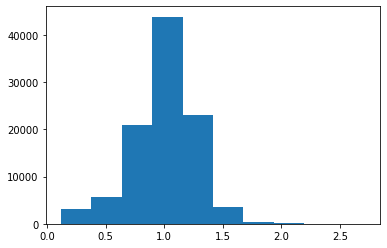

In [ ]:
plt.hist(norm_data['ratings'])

In [ ]:
ratings_dict = {'movieId': list(norm_data.movieId),
                'userId': list(norm_data.userId),
                'ratings': list(norm_data.ratings)}

norm_data = pd.DataFrame(ratings_dict)
x = norm_data.drop(['ratings'],axis=1)
y = norm_data['ratings'].astype(np.float32)

In [ ]:
import keras
from keras import layers
from keras import models

In [ ]:
input_user=layers.Input(shape=(1))
input_movie=layers.Input(shape=(1))
emb_user=layers.Embedding(n_users,n_factors)(input_user)
emb_movie=layers.Embedding(n_movies,n_factors)(input_movie)
emb=layers.concatenate([emb_user,emb_movie],axis=2)
flatten=layers.Flatten()(emb)
d1=layers.Dense(10,activation='relu')(flatten)
d2=layers.Dense(1,activation='linear')(d1)
model=models.Model(inputs=(input_user,input_movie),outputs=d2)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam',loss='mse',metrics=[keras.metrics.RootMeanSquaredError()])

In [ ]:
model.fit([x['userId'],x['movieId']],y,batch_size=32,epochs=5)

Epoch 1/5
3152/3152 [==============================] - 24s 8ms/step - loss: 0.1419 - root_mean_squared_error: 0.3563
Epoch 2/5
3152/3152 [==============================] - 24s 8ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448
Epoch 3/5
3152/3152 [==============================] - 25s 8ms/step - loss: 0.0585 - root_mean_squared_error: 0.2418
Epoch 4/5
3152/3152 [==============================] - 24s 8ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371
Epoch 5/5
3152/3152 [==============================] - 24s 8ms/step - loss: 0.0533 - root_mean_squared_error: 0.2309


In [ ]:
model.fit([x['userId'],x['movieId']],y,batch_size=32,epochs=5)

Epoch 1/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0508 - root_mean_squared_error: 0.2254
Epoch 2/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0485 - root_mean_squared_error: 0.2202
Epoch 3/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0464 - root_mean_squared_error: 0.2154
Epoch 4/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109
Epoch 5/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0428 - root_mean_squared_error: 0.2070


In [ ]:
model.fit([x['userId'],x['movieId']],y,batch_size=32,epochs=5)

Epoch 1/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035
Epoch 2/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002
Epoch 3/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0389 - root_mean_squared_error: 0.1974
Epoch 4/5
3152/3152 [==============================] - 24s 7ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949
Epoch 5/5
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928


In [ ]:
model.fit([x['userId'],x['movieId']],y,batch_size=32,epochs=10)

Epoch 1/10
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910
Epoch 2/10
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891
Epoch 3/10
3152/3152 [==============================] - 24s 8ms/step - loss: 0.0352 - root_mean_squared_error: 0.1877
Epoch 4/10
3152/3152 [==============================] - 24s 8ms/step - loss: 0.0348 - root_mean_squared_error: 0.1865
Epoch 5/10
3152/3152 [==============================] - 24s 8ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851
Epoch 6/10
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0338 - root_mean_squared_error: 0.1839
Epoch 7/10
3152/3152 [==============================] - 23s 7ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830
Epoch 8/10
3152/3152 [==============================] - 22s 7ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821
Epoch 9/10
3152/3152 [==============================] - 